In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install keras-tuner --upgrade
import pandas as pd
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalizationV2, TimeDistributed, RepeatVector, Reshape,BatchNormalization,Activation,Flatten,Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch, Hyperband, gridsearch
from keras.utils.vis_utils import plot_model
from datetime import date, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.optimizers import Adam, RMSprop, Adagrad,SGD
from statsmodels.tsa.stattools import adfuller

def first_prep(data_path):
  data=pd.read_csv(data_path)
  data["Time(year-month-day h:m:s)"] = pd.to_datetime(data["Time(year-month-day h:m:s)"])
  data= data.sort_values(by='Time(year-month-day h:m:s)', ascending=True)
  data.set_index('Time(year-month-day h:m:s)', inplace=True)
  return data

solar_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Solar-station-site-1-_Nominal-capacity-50MW_.csv')
wind_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Wind-farm-site-1-_Nominal-capacity-99MW_-_1_.csv')



**Approche univariée**





In [ ]:
Solar_Power=solar_data[['Power (MW)']].copy()
Wind_Power=wind_data[['Power (MW)']].copy()

#Split the data into train and test for solar data
train_S=Solar_Power[:int(len(solar_data)*0.8)]
test_S=Solar_Power[int(len(solar_data)*0.8):]
#Split the data into train and test
train_W=Wind_Power[:int(len(wind_data)*0.8)]
test_W=Wind_Power[int(len(wind_data)*0.8):]

def Scaler(train,test):
 sc1=StandardScaler()
 sc2=StandardScaler()
 train_scaled=sc1.fit_transform(train)
 test_scaled=sc2.fit_transform(test)
 return train_scaled,test_scaled,sc1,sc2

train_S,test_S,sc_train_S,sc_test_S=Scaler(train_S,test_S)
train_W,test_W,sc_train_W,sc_test_W=Scaler(train_W,test_W)

#split to sequence for determine the step_inputs and the step_outputs

def split_sequences(df,step_in=960,step_out=24):
 X,y=[],[]
 for i in range(step_in,len(df)-step_out):
  X.append(df[i-step_in:i])
  y.append(df[i:i+step_out])
 X=np.array(X)
 y=np.array(y)
 return X,y

X_train_S,y_train_S=split_sequences(train_S,step_in=96,step_out=24)
X_test_S,y_test_S=split_sequences(test_S,step_in=96,step_out=24)
X_train_W,y_train_W=split_sequences(train_W,step_in=96,step_out=24)
X_test_W,y_test_W=split_sequences(test_W,step_in=96,step_out=24)

def get_best_model(X_train,y_train,max_trials=5,executions_per_trial=1):

  def LSTM_model(hp):

    model_u_LSTM=Sequential()
    model_u_LSTM.add(CuDNNLSTM(hp.Int('unit_1',50,150,50),return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
    model_u_LSTM.add(Activation('relu'))
    model_u_LSTM.add(CuDNNLSTM(hp.Int('unit_2',50,150,50)))
    model_u_LSTM.add(Activation('relu'))
    model_u_LSTM.add(Dense(y_train.shape[1]))
    model_u_LSTM.compile(optimizer='adam',loss='mae',metrics=['mae','mse'])
    batch_size=hp.Int('batch_size',16,68,16)
    epochs=hp.Int('epochs',5,30,3)

    return model_u_LSTM


  tuner = RandomSearch(LSTM_model, max_trials=max_trials, objective='mse', executions_per_trial=executions_per_trial, directory='solar_wind_power_forecasting', project_name='univariate_forecasting_LSTM_1')
  es = EarlyStopping(monitor='mse', patience=5, mode='min', verbose=1, restore_best_weights = True)
  cp = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True, monitor='mse', mode='min', verbose=1)
  tuner.search(X_train, y_train, verbose=1,batch_size=32,validation_split=0.2,callbacks=[cp,es],shuffle=False)
  #Get the best_hyperpameters
  best_hyp = tuner.get_best_hyperparameters()[0]
  model = tuner.hypermodel.build(best_hyp)
  history = model.fit(X_train, y_train, validation_split=0.2, epochs=best_hyp.get('epochs'), batch_size=best_hyp.get('batch_size'), callbacks=[cp,es], verbose=1,shuffle=False)
  #model_trained= tuner.get_best_models(num_models=1)[0]

  return history,model

In [ ]:
history_u_LSTM_S,model_u_LSTM_S=get_best_model(X_train_S,y_train_S)

Epoch 1/26
1401/1401 [==============================] - ETA: 0s - loss: 0.4340 - mae: 0.4340 - mse: 0.5559
Epoch 1: mse improved from inf to 0.55591, saving model to best_model.h5
1401/1401 [==============================] - 25s 16ms/step - loss: 0.4340 - mae: 0.4340 - mse: 0.5559 - val_loss: 0.3479 - val_mae: 0.3479 - val_mse: 0.3836
Epoch 2/26
1396/1401 [============================>.] - ETA: 0s - loss: 0.2395 - mae: 0.2395 - mse: 0.2036
Epoch 2: mse improved from 0.55591 to 0.20328, saving model to best_model.h5
1401/1401 [==============================] - 16s 12ms/step - loss: 0.2394 - mae: 0.2394 - mse: 0.2033 - val_loss: 0.3118 - val_mae: 0.3118 - val_mse: 0.3261
Epoch 3/26
1400/1401 [============================>.] - ETA: 0s - loss: 0.2084 - mae: 0.2084 - mse: 0.1701
Epoch 3: mse improved from 0.20328 to 0.16999, saving model to best_model.h5
1401/1401 [==============================] - 15s 11ms/step - loss: 0.2083 - mae: 0.2083 - mse: 0.1700 - val_loss: 0.2939 - val_mae: 0.2939

In [ ]:
history_u_LSTM_W,model_u_LSTM_W=get_best_model(X_train_W,y_train_W)

In [ ]:
def history_model(model):
    plt.figure(1)
    plt.plot(model.history['mae'])
    plt.plot(model.history['val_mae'])
    plt.title('mae & val_mae')
    plt.legend(['mae', 'val_mae'])
    plt.show()

    plt.figure(2)
    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('mse & val_mse')
    plt.legend(['mse', 'val_mse'])
    plt.show()

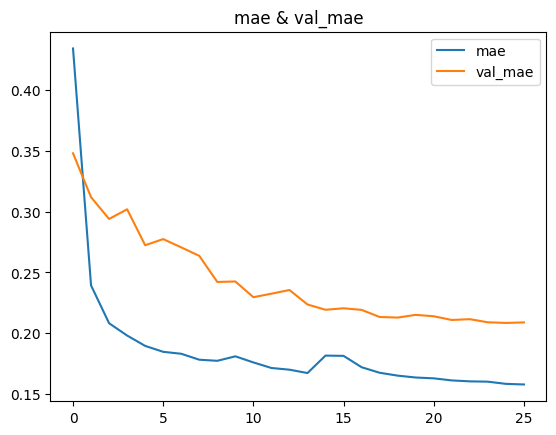

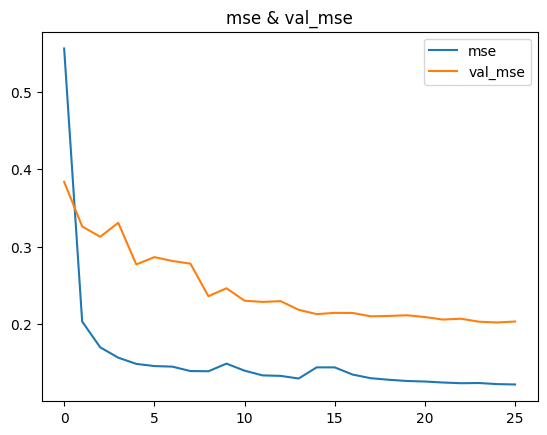

In [ ]:
history_model(history_u_LSTM_S)

In [ ]:
 y_test_S.shape

(333984, 1)

In [ ]:

 y_test_S=y_test_S.reshape(-1)

In [ ]:
 y_test_S.shape

(333984,)

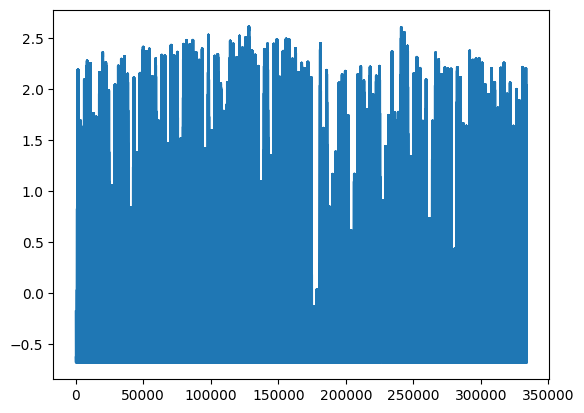

In [ ]:
plt.plot(y_test_S)

In [ ]:
def evalute_model(model,data,train,scaler,X_test,y_test,start,step_in,n_forecast,color_d):
 predictions=model.predict(X_test)
 #reshape
 predictions=predictions.reshape(-1,1)
 y_test=y_test.reshape(-1,1)
 #invesre scaler
 predictions=scaler.inverse_transform(predictions)
 y_test=scaler.inverse_transform(y_test)

 plt.figure(figsize=(10,5))
 plt.plot(data.index[len(train)+start:len(train)+step_in+start+1],y_test[start:start+step_in+1],label='12 heures avant',color=color_d)
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+start+n_forecast+1],y_test[step_in+start:step_in+start+n_forecast+1],label='6 heures aprés',color='green')
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+start+n_forecast+1],predictions[step_in+start:step_in+start+n_forecast+1],color='red',linestyle='dashed',label='prévision_RandomForest')
 plt.xlabel('Temps')
 plt.ylabel('Energie en (MW)')
 plt.legend()
 plt.title('Valeurs prévisionnelles vs Valeurs réelles')
 mae=mean_absolute_error(y_test,predictions)
 mse=mean_squared_error(y_test,predictions)
 rmse = np.sqrt(mse)
 mape = mean_absolute_percentage_error(y_test,predictions)
 print('mae=',mae)
 print('mse=',mse)
 print('rmse=',rmse)
 print('mape=',mape)
 return predictions

435/435 [==============================] - 2s 4ms/step
mae= 0.22902041306181825
mse= 0.20462741851536814
rmse= 0.45235762236903687
mape= 2.641311942187738


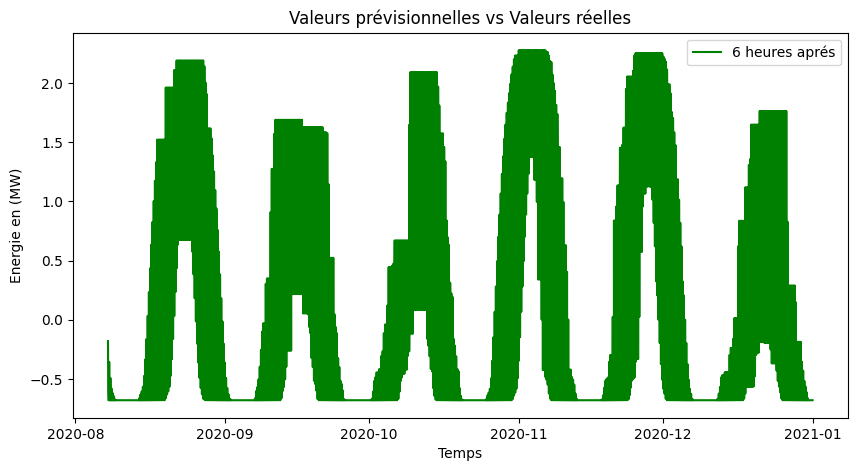

In [ ]:
predictions_u_LSTM_S=evalute_model(model_u_LSTM_S,solar_data,train_S,sc_test_S,X_test_S,y_test_S,0,96,96,'orange')

**Approche multivariée**
entrées multiples

In [ ]:
#Split the data into train and test for solar data
train_S_m=solar_data[:int(len(solar_data)*0.8)]
test_S_m=solar_data[int(len(solar_data)*0.8):]
#Split the data into train and test
train_W_m=wind_data[:int(len(wind_data)*0.8)]
test_W_m=wind_data[int(len(wind_data)*0.8):]

#split to features and label
def split_features_label(data,label):
  label=data[[label]].copy()
  features=data.drop(label,axis=1)
  scaler=StandardScaler()
  features=scaler.fit_transform(features)
  label=scaler.fit_transform(label)
  return features,label,scaler

train_features_S,train_label_S,scaler_train_s=split_features_label(train_S_m,'Power (MW)')
test_features_S,test_label_S,scaler_test_s=split_features_label(test_S_m,'Power (MW)')

train_features_W,train_label_W,scaler_train_w=split_features_label(train_W_m,'Power (MW)')
test_features_W,test_label_W,scaler_test_w=split_features_label(test_W_m,'Power (MW)')

def split_sequences_2(features,label,step_in=960,step_out=12):
 X,y=[],[]
 for i in range(step_in,len(features)-step_out):
  X.append(features[i-step_in:i])
  y.append(label[i:i+step_out])
 X=np.array(X)
 y=np.array(y)
 return X,y

X_train_S,y_train_S=split_sequences_2(train_features_S,train_label_S,step_in=672,step_out=96)
X_test_S,y_test_S=split_sequences_2(test_features_S,test_label_S,step_in=672,step_out=96)

X_train_W,y_train_W=split_sequences_2(train_features_W,train_label_W,step_in=672,step_out=96)
X_test_W,y_test_W=split_sequences_2(test_features_W,test_label_W,step_in=672,step_out=96)

In [ ]:
model_M_LSTM_S=get_best_model(X_train_S,y_train_S,10,1)